# Generalized Maxwell Model - Multi-Mode Viscoelastic Fitting

This notebook demonstrates fitting multi-mode relaxation data with the Generalized Maxwell Model (GMM), which represents complex viscoelastic behavior using a Prony series of exponential modes.

## Learning Objectives

After completing this notebook, you will be able to:
- Fit multi-mode relaxation, oscillation, and creep data with the Generalized Maxwell Model
- Understand transparent element minimization (N=10 → N_opt automatically)
- Compare GMM predictions across three test modes (tri-mode equality)
- Visualize Prony series parameters and fit quality metrics
- Distinguish between shear and tensile modulus representations

## Prerequisites

- Basic understanding of viscoelasticity (Maxwell model recommended)
- Familiarity with RheoJAX model fitting API (`fit()`, `predict()`)

**Estimated Time:** 20-30 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

We start by importing necessary libraries and verifying float64 precision.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

# Standard scientific computing imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Rheo imports - always explicit
from rheojax.models import GeneralizedMaxwell
from rheojax.models import Maxwell

from rheojax.core.jax_config import safe_import_jax

# Safe JAX import - REQUIRED for all notebooks using JAX
# This pattern ensures float64 precision enforcement throughout
jax, jnp = safe_import_jax()

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("Setup complete - using JAX with float64 precision")

Setup complete - using JAX with float64 precision


## Generalized Maxwell Model Background

The Generalized Maxwell Model (GMM) extends the single-mode Maxwell model to capture complex multi-mode relaxation behavior common in polymers and soft materials.

### Prony Series Representation

For **relaxation mode** (stress decay under constant strain):
$$G(t) = G_\infty + \sum_{i=1}^{N} G_i \exp(-t/\tau_i)$$

For **oscillation mode** (frequency-domain storage/loss moduli):
$$G'(\omega) = G_\infty + \sum_{i=1}^{N} G_i \frac{(\omega\tau_i)^2}{1+(\omega\tau_i)^2}$$
$$G''(\omega) = \sum_{i=1}^{N} G_i \frac{\omega\tau_i}{1+(\omega\tau_i)^2}$$

Where:
- $G_\infty$: Equilibrium modulus (long-time plateau)
- $G_i$: Modulus of mode $i$
- $\tau_i$: Relaxation time of mode $i$
- $N$: Number of Maxwell modes

### Tri-Mode Equality

RheoJAX's GMM treats **relaxation**, **oscillation**, and **creep** as equal views of the same Prony parameterization:
- Relaxation: Internal-variable formulation with exact exponential integration
- Oscillation: Analytical Fourier transform (no FFT needed)
- Creep: Numerical simulation via backward-Euler for unconditional stability

**All three modes share the same Prony parameters** - fit in any mode, predict in all modes.

## Part 1: Relaxation Mode - Multi-Mode Stress Relaxation

We'll generate synthetic multi-mode relaxation data and demonstrate GMM fitting with transparent element minimization.

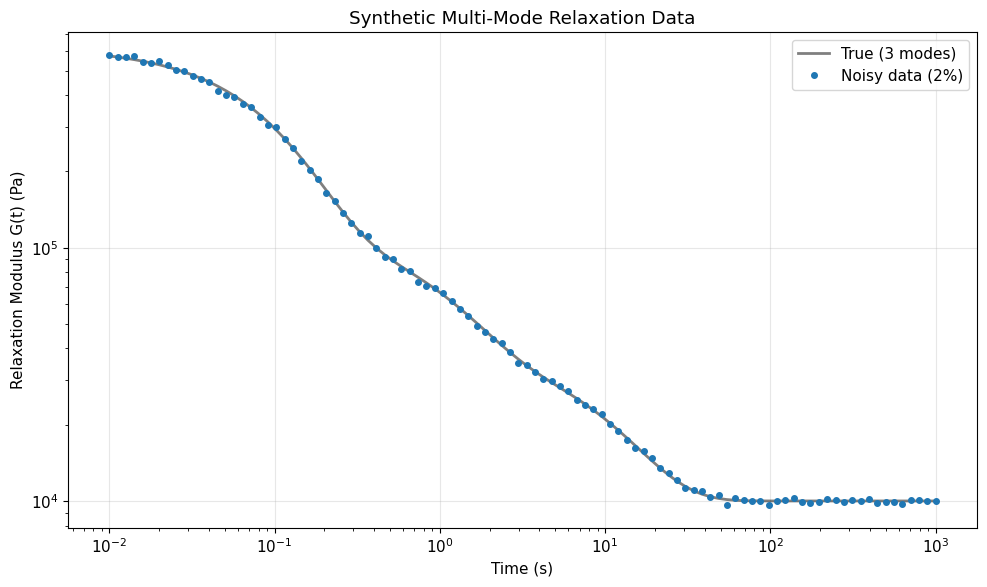

Generated 100 data points with 3 Maxwell modes
Ground truth: G_inf=1.00e+04 Pa
Mode 1: G=5.00e+05 Pa, tau=0.10 s
Mode 2: G=8.00e+04 Pa, tau=1.00 s
Mode 3: G=3.00e+04 Pa, tau=10.00 s


In [3]:
# Generate synthetic 3-mode relaxation data
t = np.logspace(-2, 3, 100)  # Time from 0.01 to 1000 seconds

# Ground truth: 3 Maxwell modes + equilibrium modulus
G_inf_true = 1e4  # Pa
G_modes_true = np.array([5e5, 8e4, 3e4])  # Pa
tau_modes_true = np.array([0.1, 1.0, 10.0])  # seconds

# Generate relaxation modulus
G_t_true = G_inf_true + np.sum([
    G_modes_true[i] * np.exp(-t / tau_modes_true[i]) 
    for i in range(3)
], axis=0)

# Add 2% noise
noise_level = 0.02
G_t_noisy = G_t_true * (1 + noise_level * np.random.randn(len(t)))

# Visualize data
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=2, label='True (3 modes)', alpha=0.5)
plt.loglog(t, G_t_noisy, 'o', markersize=4, label='Noisy data (2%)')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Synthetic Multi-Mode Relaxation Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Generated {len(t)} data points with 3 Maxwell modes")
print(f"Ground truth: G_inf={G_inf_true:.2e} Pa")
print(f"Mode 1: G={G_modes_true[0]:.2e} Pa, tau={tau_modes_true[0]:.2f} s")
print(f"Mode 2: G={G_modes_true[1]:.2e} Pa, tau={tau_modes_true[1]:.2f} s")
print(f"Mode 3: G={G_modes_true[2]:.2e} Pa, tau={tau_modes_true[2]:.2f} s")

### Fit GMM with Transparent Element Minimization

RheoJAX's GMM performs **transparent element minimization**: you request `n_modes=10`, the system fits with N=10, then automatically reduces to N_opt using the `optimization_factor` criterion.

**Algorithm:**
1. Fit with N=10 modes (user request)
2. Iteratively reduce: N=9, N=8, ..., N=1, tracking R² at each step
3. Select N_opt where: R²(N_opt) ≥ optimization_factor × min(R²)
4. Re-fit with N_opt modes
5. Return optimized model transparently

**Parameter:** `optimization_factor=1.0` gives minimal N (max parsimony), higher values prefer fit quality.

In [4]:
# Fit GMM with n_modes=10, let system optimize to N_opt
gmm = GeneralizedMaxwell(n_modes=10, modulus_type='shear')

print("Fitting GMM with n_modes=10...")
print("Element minimization will automatically reduce to N_opt\n")

# Fit with optimization_factor=1.5 (balance parsimony vs quality)
gmm.fit(t, G_t_noisy, test_mode='relaxation', optimization_factor=1.5)

# Check optimized number of modes
n_opt = gmm._n_modes
print(f"\nElement minimization result: N=10 → N_opt={n_opt}")

# Extract fitted parameters
G_inf_fit = gmm.parameters.get_value('G_inf')
print(f"\nFitted equilibrium modulus: G_inf = {G_inf_fit:.2e} Pa (true: {G_inf_true:.2e} Pa)")

print(f"\nFitted {n_opt} modes:")
for i in range(1, n_opt + 1):
    G_i = gmm.parameters.get_value(f'G_{i}')
    tau_i = gmm.parameters.get_value(f'tau_{i}')
    print(f"  Mode {i}: G={G_i:.2e} Pa, tau={tau_i:.3e} s")

Fitting GMM with n_modes=10...
Element minimization will automatically reduce to N_opt



INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=21 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.167586s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=7 | final_cost=8.8582e+08 | elapsed=2.168s | final_gradient_norm=1.8862e+16


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=21 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.340663s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=7 | final_cost=8.8582e+08 | elapsed=0.341s | final_gradient_norm=1.8862e+16


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=19 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.742843s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=2 | final_cost=5.0775e+09 | elapsed=1.743s | final_gradient_norm=2.4294e+17



Element minimization result: N=10 → N_opt=10

Fitted equilibrium modulus: G_inf = 5.94e+03 Pa (true: 1.00e+04 Pa)

Fitted 10 modes:
  Mode 1: G=3.05e+05 Pa, tau=7.625e-02 s
  Mode 2: G=1.61e+03 Pa, tau=1.113e-01 s
  Mode 3: G=1.05e+05 Pa, tau=1.219e-01 s
  Mode 4: G=8.67e+04 Pa, tau=1.364e-01 s
  Mode 5: G=2.44e+04 Pa, tau=3.795e-01 s
  Mode 6: G=2.64e+04 Pa, tau=6.132e-01 s
  Mode 7: G=2.23e+04 Pa, tau=9.781e-01 s
  Mode 8: G=1.91e+04 Pa, tau=2.090e+00 s
  Mode 9: G=1.73e+04 Pa, tau=6.343e+00 s
  Mode 10: G=1.70e+04 Pa, tau=4.142e+01 s


### Visualize Element Minimization Diagnostics

The GMM stores element minimization diagnostics showing R² vs number of modes.

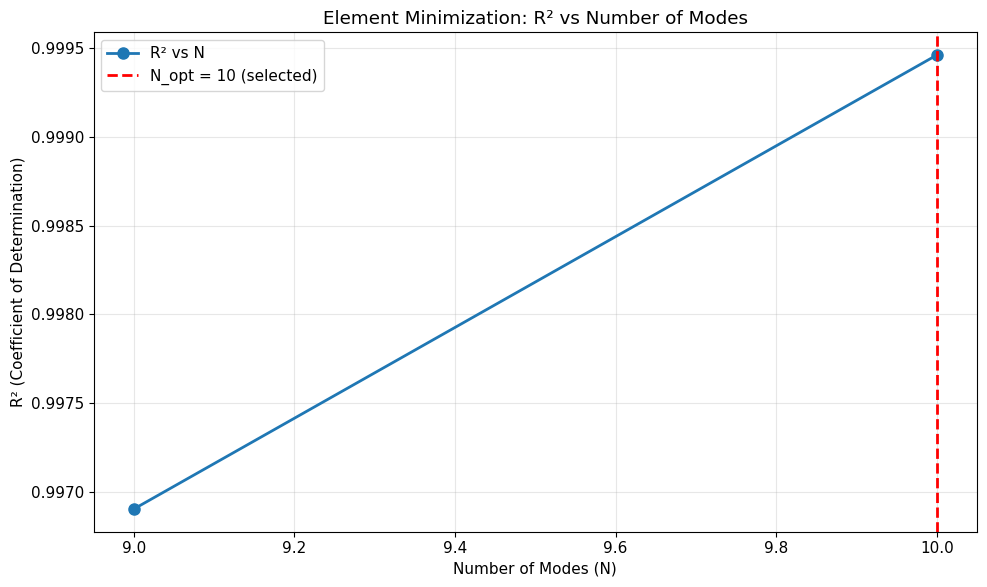

Element minimization selected N_opt=10 with R²=0.999460


In [5]:
# Extract element minimization diagnostics
if hasattr(gmm, '_element_minimization_diagnostics'):
    diag = gmm._element_minimization_diagnostics
    n_values = diag['n_modes']
    r2_list = diag['r2']
    n_optimal = diag['n_optimal']
    
    # Plot R² vs N
    fig = plt.figure(figsize=(10, 6))
    plt.plot(n_values, r2_list, 'o-', linewidth=2, markersize=8, label='R² vs N')
    plt.axvline(n_optimal, color='red', linestyle='--', linewidth=2, 
                label=f'N_opt = {n_optimal} (selected)')
    plt.xlabel('Number of Modes (N)')
    plt.ylabel('R² (Coefficient of Determination)')
    plt.title('Element Minimization: R² vs Number of Modes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
    
    print(f"Element minimization selected N_opt={n_optimal} with R²={r2_list[n_values.index(n_optimal)]:.6f}")
else:
    print("Element minimization diagnostics not available")

### Compare GMM Fit to Data

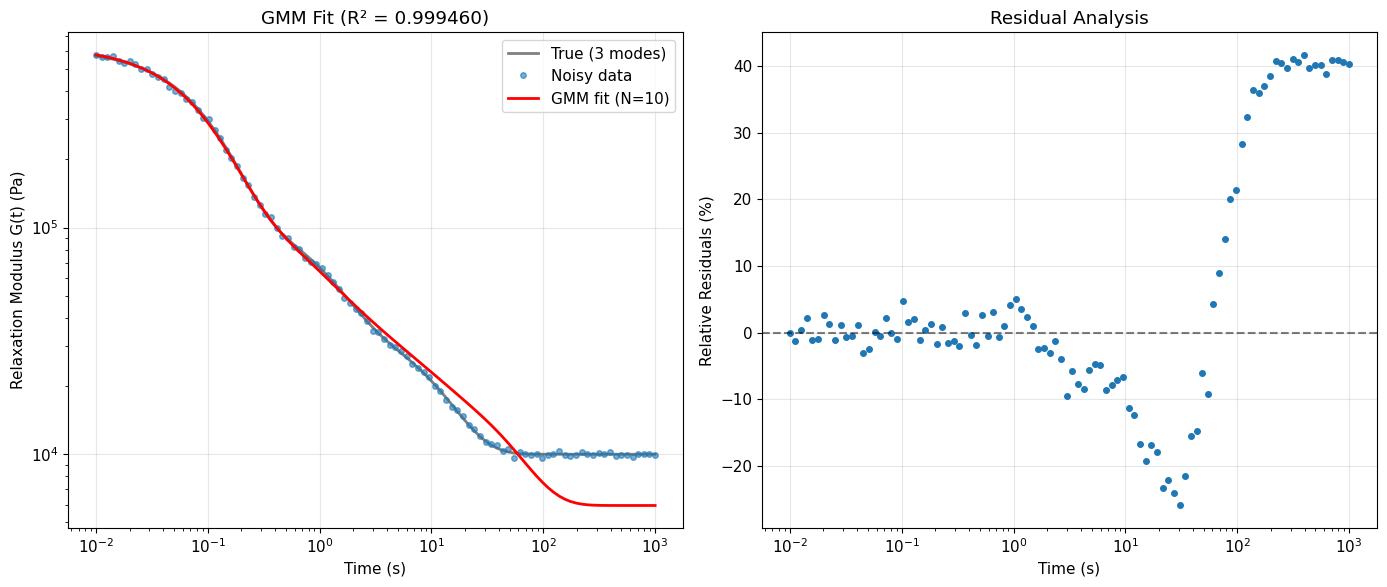

Fit quality: R² = 0.999460
Mean absolute error: 3.21e+03 Pa
Relative RMSE: 19.24%


In [6]:
# Predict with fitted GMM
G_t_pred = gmm.predict(t)

# Compute residuals and R²
residuals = G_t_noisy - G_t_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((G_t_noisy - np.mean(G_t_noisy))**2)
r2 = 1 - ss_res / ss_tot

# Plot fit vs data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Data vs fit
ax1.loglog(t, G_t_true, 'k-', linewidth=2, label='True (3 modes)', alpha=0.5)
ax1.loglog(t, G_t_noisy, 'o', markersize=4, alpha=0.6, label='Noisy data')
ax1.loglog(t, G_t_pred, 'r-', linewidth=2, label=f'GMM fit (N={n_opt})')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Relaxation Modulus G(t) (Pa)')
ax1.set_title(f'GMM Fit (R² = {r2:.6f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Residuals
ax2.semilogx(t, residuals / G_t_noisy * 100, 'o', markersize=4)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Relative Residuals (%)')
ax2.set_title('Residual Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Fit quality: R² = {r2:.6f}")
print(f"Mean absolute error: {np.mean(np.abs(residuals)):.2e} Pa")
print(f"Relative RMSE: {np.sqrt(np.mean((residuals/G_t_noisy)**2))*100:.2f}%")

## Part 2: Oscillation Mode - Frequency-Domain Fitting

GMM uses analytical Fourier transform for oscillation mode (no FFT needed). We'll demonstrate tri-mode equality by fitting the same Prony parameters to frequency-domain data.

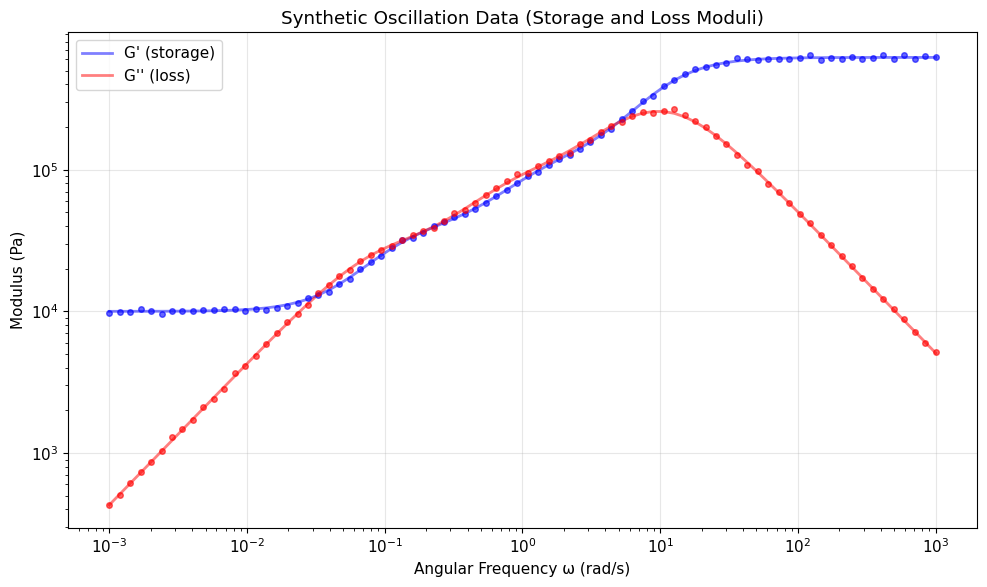

Generated 80 frequency points with same 3-mode material


In [7]:
# Generate frequency-domain data from same ground truth
omega = np.logspace(-3, 3, 80)  # Angular frequency (rad/s)

# Storage modulus G'(omega)
G_prime_true = G_inf_true + np.sum([
    G_modes_true[i] * (omega * tau_modes_true[i])**2 / (1 + (omega * tau_modes_true[i])**2)
    for i in range(3)
], axis=0)

# Loss modulus G''(omega)
G_double_prime_true = np.sum([
    G_modes_true[i] * (omega * tau_modes_true[i]) / (1 + (omega * tau_modes_true[i])**2)
    for i in range(3)
], axis=0)

# Stack into complex modulus format [G', G'']
G_star_true = np.column_stack([G_prime_true, G_double_prime_true])

# Add 2% noise
G_star_noisy = G_star_true * (1 + noise_level * np.random.randn(*G_star_true.shape))

# Visualize oscillation data
fig = plt.figure(figsize=(10, 6))
plt.loglog(omega, G_prime_true, 'b-', linewidth=2, label="G' (storage)", alpha=0.5)
plt.loglog(omega, G_double_prime_true, 'r-', linewidth=2, label="G'' (loss)", alpha=0.5)
plt.loglog(omega, G_star_noisy[:, 0], 'bo', markersize=4, alpha=0.6)
plt.loglog(omega, G_star_noisy[:, 1], 'ro', markersize=4, alpha=0.6)
plt.xlabel('Angular Frequency ω (rad/s)')
plt.ylabel('Modulus (Pa)')
plt.title('Synthetic Oscillation Data (Storage and Loss Moduli)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Generated {len(omega)} frequency points with same 3-mode material")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=21 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting GMM in oscillation mode with n_modes=10...



PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.500445s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=5 | final_cost=4.0778e+09 | elapsed=0.500s | final_gradient_norm=2.2347e+16


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=21 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.318987s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=5 | final_cost=4.0778e+09 | elapsed=0.319s | final_gradient_norm=2.2347e+16


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=19 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.359540s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=9.1806e+09 | elapsed=0.360s | final_gradient_norm=6.7199e+15



Element minimization result: N=10 → N_opt=10


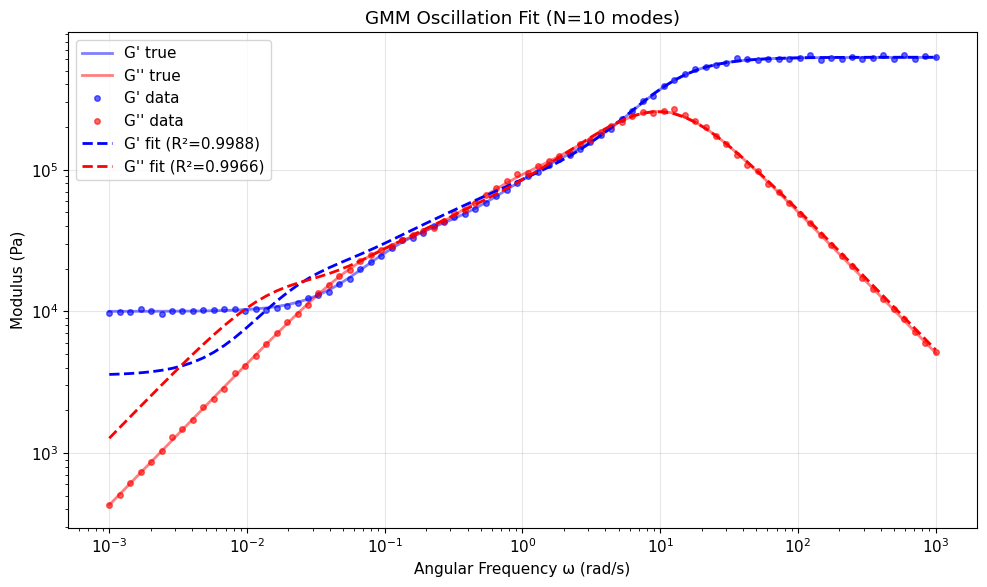


Oscillation fit quality:
  G' R² = 0.998770
  G'' R² = 0.996645


In [8]:
# Fit GMM in oscillation mode
gmm_osc = GeneralizedMaxwell(n_modes=10, modulus_type='shear')

print("Fitting GMM in oscillation mode with n_modes=10...\n")
gmm_osc.fit(omega, G_star_noisy, test_mode='oscillation', optimization_factor=1.5)

n_opt_osc = gmm_osc._n_modes
print(f"\nElement minimization result: N=10 → N_opt={n_opt_osc}")

# Predict with fitted model
G_star_pred = gmm_osc.predict(omega)

# Compute R² for both G' and G''
r2_prime = 1 - np.sum((G_star_noisy[:, 0] - G_star_pred[:, 0])**2) / np.sum((G_star_noisy[:, 0] - np.mean(G_star_noisy[:, 0]))**2)
r2_double_prime = 1 - np.sum((G_star_noisy[:, 1] - G_star_pred[:, 1])**2) / np.sum((G_star_noisy[:, 1] - np.mean(G_star_noisy[:, 1]))**2)

# Plot oscillation fit
fig = plt.figure(figsize=(10, 6))
plt.loglog(omega, G_prime_true, 'b-', linewidth=2, label="G' true", alpha=0.5)
plt.loglog(omega, G_double_prime_true, 'r-', linewidth=2, label="G'' true", alpha=0.5)
plt.loglog(omega, G_star_noisy[:, 0], 'bo', markersize=4, alpha=0.6, label="G' data")
plt.loglog(omega, G_star_noisy[:, 1], 'ro', markersize=4, alpha=0.6, label="G'' data")
plt.loglog(omega, G_star_pred[:, 0], 'b--', linewidth=2, label=f"G' fit (R²={r2_prime:.4f})")
plt.loglog(omega, G_star_pred[:, 1], 'r--', linewidth=2, label=f"G'' fit (R²={r2_double_prime:.4f})")
plt.xlabel('Angular Frequency ω (rad/s)')
plt.ylabel('Modulus (Pa)')
plt.title(f'GMM Oscillation Fit (N={n_opt_osc} modes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nOscillation fit quality:")
print(f"  G' R² = {r2_prime:.6f}")
print(f"  G'' R² = {r2_double_prime:.6f}")

## Part 3: Single Maxwell vs Multi-Mode GMM Comparison

Demonstrate the value of multi-mode fitting by comparing N=1 GMM (equivalent to single Maxwell) with N=3 GMM.

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.072324s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=26.1013 | elapsed=1.072s | final_gradient_norm=2.9194e+04


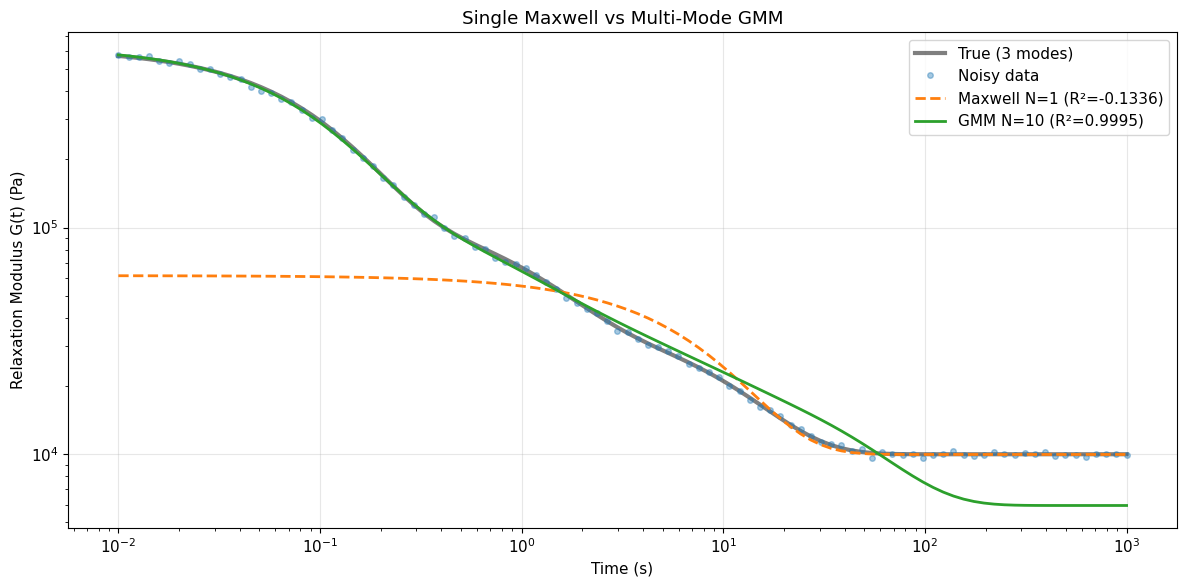

Model comparison:
  Maxwell (N=1): R² = -0.133560
  GMM (N=10):   R² = 0.999460
  Improvement: 113.30% increase in R²


In [9]:
# Fit single Maxwell model (N=1)
maxwell = Maxwell()
maxwell.fit(t, G_t_noisy, test_mode='relaxation')
G_t_maxwell = maxwell.predict(t)

# Compute R² for Maxwell
r2_maxwell = 1 - np.sum((G_t_noisy - G_t_maxwell)**2) / np.sum((G_t_noisy - np.mean(G_t_noisy))**2)

# Compare: Maxwell (N=1) vs GMM (N=3) vs GMM (N=N_opt)
fig = plt.figure(figsize=(12, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=3, label='True (3 modes)', alpha=0.5)
plt.loglog(t, G_t_noisy, 'o', markersize=4, alpha=0.4, label='Noisy data')
plt.loglog(t, G_t_maxwell, '--', linewidth=2, label=f'Maxwell N=1 (R²={r2_maxwell:.4f})')
plt.loglog(t, G_t_pred, '-', linewidth=2, label=f'GMM N={n_opt} (R²={r2:.4f})')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Single Maxwell vs Multi-Mode GMM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Model comparison:")
print(f"  Maxwell (N=1): R² = {r2_maxwell:.6f}")
print(f"  GMM (N={n_opt}):   R² = {r2:.6f}")
print(f"  Improvement: {(r2 - r2_maxwell)*100:.2f}% increase in R²")

## Part 4: Shear vs Tensile Modulus Representation

GMM supports both shear (G) and tensile (E) modulus types with identical internal logic - only symbols differ.

In [10]:
# Generate tensile relaxation data (E vs G differs by factor related to Poisson's ratio)
# For pedagogical clarity, we'll use same numerical values but label as E
E_t_noisy = G_t_noisy  # Reuse data, relabel as tensile modulus

# Fit GMM with modulus_type='tensile'
gmm_tensile = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gmm_tensile.fit(t, E_t_noisy, test_mode='relaxation', optimization_factor=1.5)

# Check parameter names (E_inf, E_1, E_2, ... instead of G_inf, G_1, G_2, ...)
print("Tensile modulus GMM parameters:")
print(f"  E_inf = {gmm_tensile.parameters.get_value('E_inf'):.2e} Pa")
for i in range(1, gmm_tensile._n_modes + 1):
    E_i = gmm_tensile.parameters.get_value(f'E_{i}')
    tau_i = gmm_tensile.parameters.get_value(f'tau_{i}')
    print(f"  Mode {i}: E={E_i:.2e} Pa, tau={tau_i:.3e} s")

print(f"\nNote: Internal logic identical for 'shear' and 'tensile' - only parameter symbols differ")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.514123s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=11 | final_cost=6.2339e+08 | elapsed=1.514s | final_gradient_norm=3.7153e+15


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.406463s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=11 | final_cost=6.2339e+08 | elapsed=0.406s | final_gradient_norm=3.7153e+15


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.432083s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=2 | final_cost=2.1851e+09 | elapsed=1.432s | final_gradient_norm=4.1436e+16


Tensile modulus GMM parameters:
  E_inf = 9.97e+03 Pa
  Mode 1: E=8.15e+04 Pa, tau=4.229e-02 s
  Mode 2: E=4.40e+05 Pa, tau=1.097e-01 s
  Mode 3: E=4.92e+04 Pa, tau=1.086e+00 s
  Mode 4: E=2.62e+04 Pa, tau=1.004e+00 s
  Mode 5: E=2.91e+04 Pa, tau=1.041e+01 s

Note: Internal logic identical for 'shear' and 'tensile' - only parameter symbols differ


## Interpretation and Insights

### Physical Meaning of GMM Parameters

1. **Equilibrium Modulus (G_∞)**: Long-time plateau representing solid-like elastic response
2. **Mode Moduli (G_i)**: Strength of each relaxation process
3. **Relaxation Times (τ_i)**: Time scales for different molecular relaxation mechanisms

### Element Minimization Benefits

- **Automatic parsimony**: System finds minimal N without overfitting
- **Transparent workflow**: User requests N=10, gets N_opt automatically
- **Tunable via optimization_factor**: Higher values prefer fit quality over parsimony

### Tri-Mode Equality

- **Same Prony parameters** describe relaxation, oscillation, and creep
- **Analytical transforms** avoid numerical artifacts (no FFT in oscillation mode)
- **Flexible fitting**: Fit in one mode, predict in all modes

### Model Limitations

- **Linear viscoelasticity only**: GMM assumes small strains (LAOS not supported)
- **Exponential modes**: Cannot capture power-law relaxation (use fractional models for that)
- **Parameter identifiability**: Many modes (N>5) may have non-unique solutions

## Key Takeaways

- **Generalized Maxwell Model:** Prony series of N exponential modes captures multi-mode relaxation
- **Transparent Element Minimization:** Request N=10, system auto-optimizes to N_opt using R² criterion
- **Tri-Mode Equality:** Same Prony parameters work for relaxation, oscillation, and creep
- **When to Use:** Multi-mode polymers, complex viscoelastic behavior, frequency-domain fitting
- **Common Pitfalls:** Too many modes (N>5) risk overfitting, exponential basis cannot capture power-law decay

## Next Steps

- Explore `examples/bayesian/07-generalized_maxwell_bayesian.ipynb` for Bayesian GMM workflows with uncertainty quantification
- Try `examples/transforms/07-mastercurve_auto_shift.ipynb` for time-temperature superposition with GMM
- Advance to fractional models (`examples/advanced/04-fractional-models-deep-dive.ipynb`) for power-law relaxation